# Cross Validation - Gabbar

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

In [3]:
from sklearn.model_selection import cross_val_score

In [4]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [5]:
random_state = 5
cv = 10

In [6]:
non_training_attributes = ['changeset_id', 'changeset_harmful', 'feature_id', 'new_tags', 'old_tags']

In [7]:
labelled_path = '../downloads/highway-classifier/labelled/'

In [8]:
labelled = pd.read_csv(labelled_path + 'attributes.csv')
print(labelled.shape)

# Sort the dataset randomly.
labelled = labelled.sample(labelled.shape[0], random_state=random_state)
labelled.head()

(2732, 16)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags
2024,47069264,0,4748048048,2,0,1,0,1,0,0,0.00,0,11,11,NaN,{operator=SPTrans}
2311,46527869,0,62794308,3,0,1,0,1,0,0,0.00,0,187,579,NaN,{highway=turning_loop}
1585,47361809,0,23651285,6,0,1,0,0,1,0,0.16,0,1281,10,NaN,{surface=asphalt}
2166,46892332,0,45105818,6,0,1,0,0,1,0,0.03,0,1,606,{highway=footway},{highway=cycleway}
1323,47419169,0,73058399,18,0,1,0,0,1,0,0.25,0,477,1498,NaN,{surface=asphalt}


In [9]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(labelled.shape))
labelled = labelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(labelled.shape))

Shape before dropping duplicates: (2732, 16)
Shape after dropping duplicates: (2732, 16)


In [10]:
# Fill null values in tags with empty string.
labelled['old_tags'] = labelled['old_tags'].fillna('')
labelled['new_tags'] = labelled['new_tags'].fillna('')

In [11]:
from sklearn.externals import joblib

model = joblib.load('../gabbar/trained/model.pkl')
new_vectorizer = joblib.load('../gabbar/trained/new_vectorizer.pkl')
old_vectorizer = joblib.load('../gabbar/trained/old_vectorizer.pkl')

In [12]:
# Vectorize old_tags.
old_vectorized = pd.DataFrame(old_vectorizer.transform(labelled['old_tags']).toarray(), columns=old_vectorizer.get_feature_names())
old_vectorized.columns = ['old_{}'.format(item) for item in old_vectorized.columns]

# Vectorize new_tags.
new_vectorized = pd.DataFrame(new_vectorizer.transform(labelled['new_tags']).toarray(), columns=new_vectorizer.get_feature_names())
new_vectorized.columns = ['new_{}'.format(item) for item in new_vectorized.columns]

In [13]:
# Concatenate both initial validation data and vectorized data.
labelled = pd.concat([labelled, new_vectorized, old_vectorized], axis=1)
print(labelled.shape)
labelled.head()

(2732, 96)


,changeset_id,changeset_harmful,feature_id,feature_version,action_create,action_modify,action_delete,geometry_type_node,geometry_type_way,geometry_type_relation,geometry_line_distance,geometry_kinks,old_user_mapping_days,new_user_mapping_days,old_tags,new_tags,new_barrier=yes,new_bicycle=no,new_bicycle=yes,new_bridge=yes,new_construction=motorway,new_foot=yes,new_footway=sidewalk,new_highway=coastline,new_highway=footway,new_highway=living_street,new_highway=motorway,new_highway=path,new_highway=primary,new_highway=residential,new_highway=road,new_highway=secondary,new_highway=service,new_highway=tertiary,new_highway=track,new_highway=unclassified,new_horse=no,new_horse=yes,new_landuse=cemetery,new_landuse=footway,new_landuse=forest,new_landuse=grass,new_landuse=recreation_ground,new_landuse_1=park,new_landuse_1=recreation_ground,new_landuse_2=festival area,new_landuse_3=dog park,new_landuse_3=recreation,new_landuse_4=recreation_ground,new_landuse_5=water_park,new_lanes=1,new_lanes=2,new_layer=1,new_leisure=park,new_lit=yes,new_maxspeed=10 mph,new_maxspeed=20,new_maxspeed=50,new_maxspeed=8,new_natural=footway,new_natural=tree_row,new_noname=yes,new_oneway=no,new_oneway=yes,new_park=yes,new_surface=asphalt,new_surface=dirt,new_surface=grass,new_surface=gravel,new_surface=unpaved,new_surface_1=asphalt,new_surface_1=ground,new_surface_2=unpaved,new_surface_2=wood,new_tourism=attraction,new_tracktype=grade3,new_waterway=canal,new_waterway=river,new_waterway=stream,old_construction=path,old_embankment=yes,old_highway=construction,old_highway=footway,old_highway=path,old_highway=pedestrian,old_highway=primary,old_highway=residential,old_highway=service,old_highway=tertiary,old_highway=unclassified,old_lit=no,old_maxspeed=30,old_natural=coastline,old_oneway=yes,old_park=paseo,old_width=0
0,49685016,0,500704692,3,0,1,0,0,1,0,0.21,0,1009,4,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,49684098,0,501945519,3,0,1,0,0,1,0,0.27,0,11,11,,{lit=yes} {surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,49684091,0,138497224,2,0,1,0,0,1,0,0.61,0,299,118,,{destination=Camp Petersville} {destination:st...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,49670591,0,352893567,3,0,1,0,0,1,0,0.29,0,159,14,,{surface=asphalt},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,49633151,0,292617978,9,0,1,0,0,1,0,41.34,0,67,67,{highway=unclassified},{highway=tertiary},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
X = labelled.drop(non_training_attributes, axis=1)
y = labelled['changeset_harmful']

In [15]:
metrics = ['precision', 'recall', 'f1']
index = []
scores = []

for cv in [2, 3, 5, 10, 20, 40, 80, 160, 320]:
    temp_scores = []
    for metric in metrics:
        temp_score = cross_val_score(model, X, y, cv=cv, scoring=metric)
        # Using just the mean.
        temp_scores.append(temp_score.mean())
    scores.append(temp_scores)
    index.append(cv)

In [16]:
scores = pd.DataFrame(scores, columns=['precision', 'recall', 'f1_score'], index=index)
print(scores.shape)
scores.head()

(9, 3)


,precision,recall,f1_score
2,6.38e-02,0.08,6.91e-02
3,9.13e-02,0.08,7.73e-02
5,6.45e-03,0.01,8.70e-03
10,1.75e-02,0.03,1.94e-02
20,3.08e-02,0.07,4.10e-02


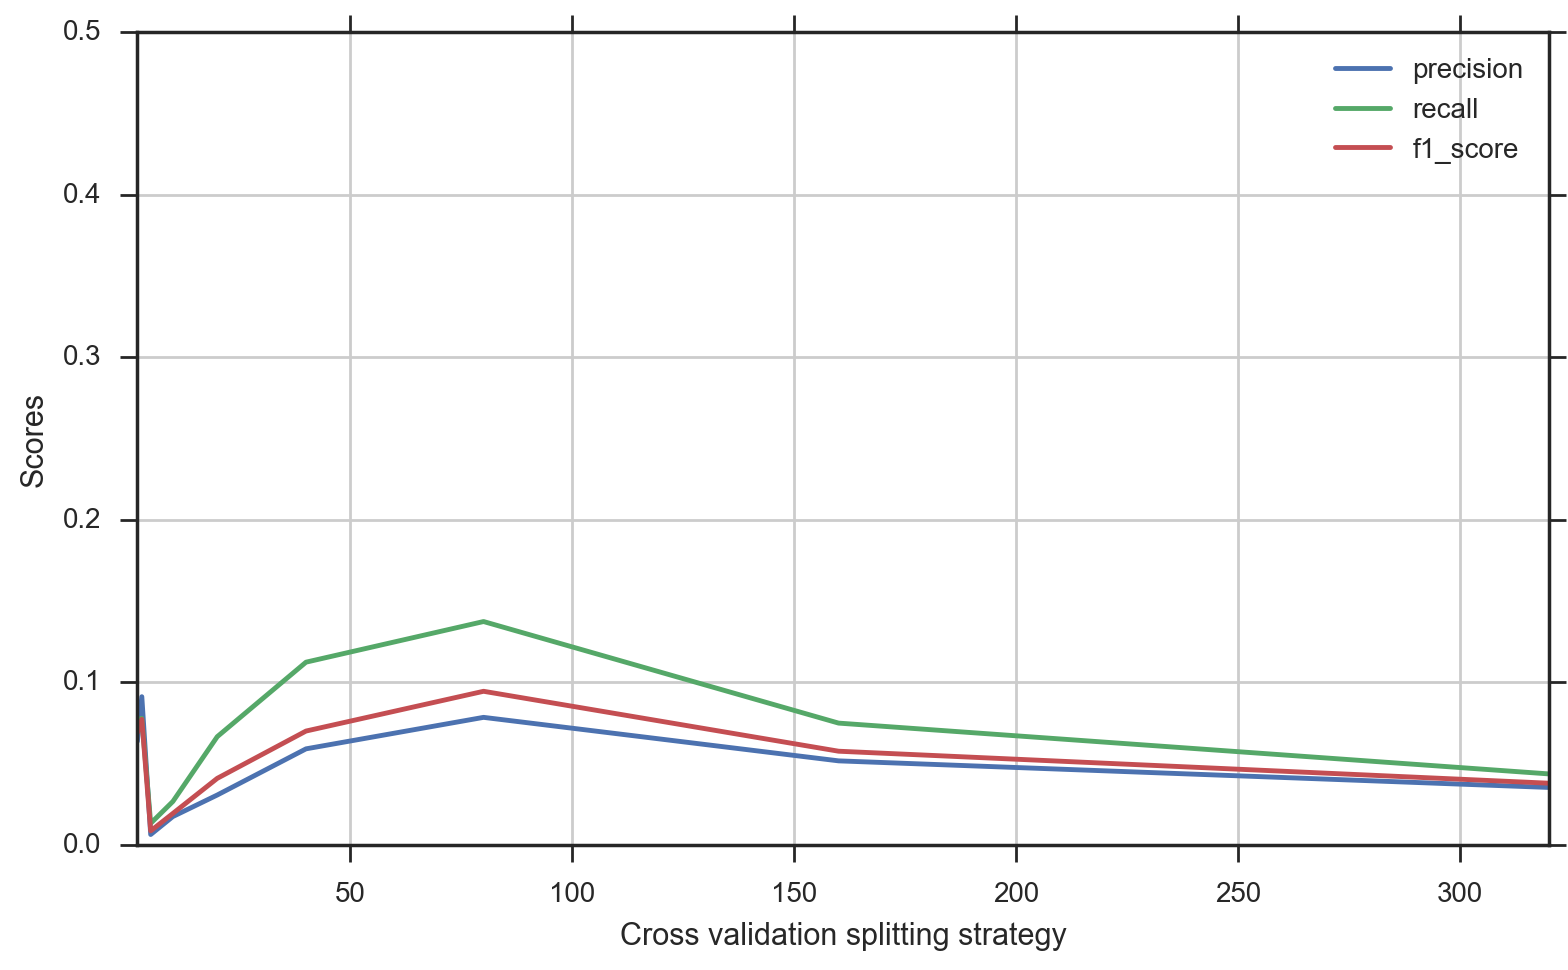

In [17]:
axes = scores.plot(figsize=(8, 5))
axes.set_xlabel('Cross validation splitting strategy')
axes.set_ylabel('Scores')
axes.set_ylim(0, 0.5)
# axes.set_xticks(np.arange(0, 100, 10))
plt.grid()
plt.tight_layout()